In [1]:
# step into the yolov4-deepsort folder
%cd /Users/pierreballesta/Foot/yolov4

/Users/pierreballesta/Foot/yolov4


In [2]:
import cv2 as cv
import numpy as np
from PIL import Image
import sys
import time
from deep_sort import preprocessing, nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
import tensorflow as tf
from absl import app, flags, logging
from absl.flags import FLAGS
from core.yolov4 import YOLO, decode, filter_boxes
import core.utils as utils
from core.config import cfg
import gc
import pickle
import matplotlib.pyplot as plt
import shutil
import os

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2021-07-01 09:51:37.041492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-01 09:51:37.041596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
#ffmpeg_extract_subclip('/Users/pierreballesta/Foot/chasuble.mp4', 300, 480, targetname='/Users/pierreballesta/Foot/chasuble_short.mp4')

In [4]:
flags.DEFINE_string('weights', './data/yolov4.weights', 'path to weights file')
flags.DEFINE_string('patches_save', '/Users/pierreballesta/Foot/patches_save', 'path to weights file')
flags.DEFINE_string('output', '/checkpoints/yolov4-416', 'path to output')
flags.DEFINE_string('movies', '/Users/pierreballesta/Foot/chasuble_short.mp4', 'path to movie')
flags.DEFINE_boolean('tiny', False, 'is yolo-tiny or not')
flags.DEFINE_integer('input_size', 416, 'define input size of export model')
flags.DEFINE_float('score_thres', 0.2, 'define score threshold')
flags.DEFINE_string('framework', 'tf', 'define what framework do you want to convert (tf, trt, tflite)')
flags.DEFINE_string('model', 'yolov4', 'yolov3 or yolov4')
flags.DEFINE_float('iou', 0.7, 'iou threshold')
flags.DEFINE_float('score', 0.50, 'score threshold')
flags.DEFINE_integer('images_paral', 128, 'number of images in a batch')
flags.DEFINE_integer('batch_size', 8, 'number of images in a batch')
flags.DEFINE_boolean('count', False, 'count objects being tracked on screen')

In [5]:
# Using FLAGS.`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
    app.run(lambda argv: None)
except:
    pass

In [7]:
shutil.rmtree(FLAGS.patches_save,ignore_errors=True)

In [8]:
STRIDES, ANCHORS, NUM_CLASS, XYSCALE = utils.load_config(FLAGS)

In [9]:
input_layer = tf.keras.layers.Input([416, 416, 3])
feature_maps = YOLO(input_layer, 80, 'yolov4', is_tiny=FLAGS.tiny)
bbox_tensors = []
prob_tensors = []

In [10]:
# load the pre-trained model.
infer = tf.keras.models.load_model('/Users/pierreballesta/Foot/yolov4/checkpoints/yolov4-416',compile=False)

In [11]:
max_cosine_distance = 0.4
nn_budget = None
nms_max_overlap = 1.0

In [12]:
# load metric if further training is needed.
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [13]:
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=2)
# calculate cosine distance metric
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
# initialize tracker

2021-07-01 09:53:01.060393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-01 09:53:01.060413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# video values.
vid = cv.VideoCapture(FLAGS.movies)
return_value, frame = vid.read()
original_h, original_w, _ = frame.shape
frame_shape = frame.shape
vid.release()

In [15]:
# to remove the background we calculate the median over n_im images. This takes some minutes.
n_im = 500
vid = cv.VideoCapture(FLAGS.movies)
vid_length = int(vid.get(cv.CAP_PROP_FRAME_COUNT))
df = (vid_length-1)/n_im
image_data = np.ones([n_im,original_h, original_w,3], dtype=np.uint8)
for i in range(n_im):
    im_num = np.int(i*df)
    vid.set(cv.CAP_PROP_POS_FRAMES, im_num)
    return_value, frame = vid.read()
    if return_value:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    else:
        print('Video has ended or failed, try a different video format!')
        vid.release()
        break
    image_data[i] = frame
vid.release()
gc.collect()

136273

In [16]:
film_median = tf.cast(np.median(image_data,axis=0),tf.int16)
del image_data
gc.collect()

0

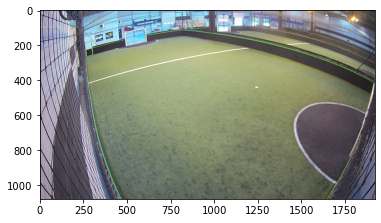

In [17]:
plt.imshow(film_median)

We create a generator so that many images can be treated in parallels. This also allows for the movie to be treated in batches saved as we advanced to save ram.

In [18]:
def movie_iter():    
    vid = cv.VideoCapture(FLAGS.movies)
    while True:
        return_value, frame = vid.read()
        if return_value:
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        else:
            print('Video has ended or failed, try a different video format!')
            vid.release()
            break
        yield tf.constant(frame, shape=frame.shape)

ds_counter = tf.data.Dataset.from_generator(movie_iter, output_signature=(
         tf.TensorSpec(shape=frame_shape, dtype=tf.uint8)))

ds_counter = ds_counter.batch(FLAGS.images_paral, drop_remainder=False)

In [19]:
# modified helper function.
def format_boxes(bboxes, image_height, image_width):
    ymin = np.int16(bboxes[:,:,0] * image_height)
    xmin = np.int16(bboxes[:,:,1] * image_width)
    ymax = np.int16(bboxes[:,:,2] * image_height)
    xmax = np.int16(bboxes[:,:,3] * image_width)
    width = xmax - xmin
    height = ymax - ymin
    bboxes[:,:,0], bboxes[:,:,1], bboxes[:,:,2], bboxes[:,:,3] = xmin, ymin, width, height
    return bboxes

In [20]:
def remove_background(itt,film_median):
    u8_0 = tf.cast(0,tf.uint8)
    u8_1 = tf.cast(1,tf.uint8)
    tut = tf.math.abs(itt-film_median)
    tut = tf.math.reduce_sum(tut, axis=-1, keepdims=True)
    tut = tf.where(tut<24,u8_0,u8_1)
    frames = tut*tf.cast(itt,tf.uint8)
    return frames

In [21]:
iterator = iter(ds_counter)
bboxes_tot = np.array([])
scores_tot = np.array([])
classes_tot = np.array([])
valid_detections_tot = np.array([])
start_time = time.monotonic()
start_time0 = time.monotonic()
start_time = time.monotonic()
for frames in iterator:
    batch_size = tf.shape(frames)[0]
    frames = remove_background(tf.cast(frames,tf.int16),film_median)
    # prediction.
    tut = infer.predict(tf.image.resize(tf.cast(frames,tf.float32),(416,416))/255.,batch_size=FLAGS.batch_size)
    # separate boxes and class probabilities.
    boxes = tut[:, :, 0:4]
    pred_conf = tut[:, :, 4:]
    # We take the 24 most probable detections.
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (batch_size, -1, 1, 4)),
            scores=tf.reshape(
            pred_conf, (batch_size, -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=24,
            max_total_size=24,
            iou_threshold=FLAGS.iou,
            score_threshold=FLAGS.score
        )  

    boxes = boxes.numpy()
    scores = scores.numpy()
    classes = classes.numpy()
    valid_detections = valid_detections.numpy()
    if bboxes_tot.size > 0:
        bboxes_tot = np.concatenate([bboxes_tot,boxes])
        scores_tot = np.concatenate([scores_tot,scores])
        classes_tot = np.concatenate([classes_tot,classes])
        valid_detections_tot = np.concatenate([valid_detections_tot, valid_detections])
    else : 
        bboxes_tot = boxes
        scores_tot = scores
        classes_tot = classes
        valid_detections_tot = valid_detections
    # clear the memory
    gc.collect()
    # frequency.
    print(FLAGS.images_paral/(time.monotonic()-start_time))
    start_time = time.monotonic()
print('total time (s) ',time.monotonic()-start_time0)


2021-07-01 09:53:49.918175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-01 09:53:49.918548: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-07-01 09:53:56.310944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3.439420085022262
3.9725922737565225
4.050835698919502
4.114859007832026
4.166606050550901
4.1815815014838185
4.033485052727587
4.299694790112312
4.380697306748708
4.328120233305199
4.326567775127724


KeyboardInterrupt: 

In [ ]:
num_objects = int(valid_detections_tot.max())
print(num_objects)
bboxes_tot = format_boxes(bboxes_tot, original_h, original_w)
bboxes_tot = bboxes_tot[:,0:num_objects]
scores_tot = scores_tot[:,0:num_objects]
classes_tot = classes_tot[:,0:num_objects]

In [ ]:
pred_bbox_tot = [bboxes_tot, scores_tot, classes_tot]
pickle.dump( pred_bbox_tot, open( "test.p", "wb" ) )

In [22]:
file = open("test.p",'rb')
pred_bbox_tot = pickle.load(file)
file.close()

In [23]:
bboxes_tot = pred_bbox_tot[0]
scores_tot = pred_bbox_tot[1]
classes_tot = pred_bbox_tot[2]

In [24]:
bboxes_tot.shape

(4500, 12, 4)

In [25]:
# read in all class names from config
class_names = utils.read_class_names(cfg.YOLO.CLASSES)

# by default allow all classes in .names file
#allowed_classes = list(class_names.values())
        
# custom allowed classes (uncomment line below to customize tracker for only people)
allowed_classes = ['person','sports ball']

indexes = []

classes_ind = [i for i in class_names if class_names[i] in allowed_classes]
# To use deep sort we need to move from batch to single images.
vid = cv.VideoCapture(FLAGS.movies)

# Let's check that the length are the same.
if not int(vid.get(cv.CAP_PROP_FRAME_COUNT)) == len(bboxes_tot):
    print("Video and data don't have the same length, using the smaller one.")
    num_loops = min(int(vid.get(cv.CAP_PROP_FRAME_COUNT)), len(bboxes_tot))
else :
    num_loops = int(vid.get(cv.CAP_PROP_FRAME_COUNT))

# create the patches folder
if not os.path.exists(FLAGS.patches_save):
    os.mkdir(FLAGS.patches_save)

In [62]:
start_time = time.monotonic()
iterator = iter(ds_counter)
i = 0

for itt in iterator:
    batch_size = tf.shape(itt)[0]
    frames = remove_background(tf.cast(itt,tf.int16),film_median)
    for frame in frames:
    # loop through objects and use class index to get class name, allow only classes in allowed_classes list
        frame = frame.numpy()
        bboxes = bboxes_tot[i]
        scores = scores_tot[i]
        classes = classes_tot[i]
        deleted_indx = [j for j in range(len(classes)) if (not int(classes[j]) in classes_ind) 
                    or (np.array_equal(bboxes[j],np.array([0,0,0,0])))]
        names = np.array([class_names[int(classes[j])] for j in range(len(classes)) if not j in deleted_indx])
        bboxes = np.delete(bboxes, deleted_indx, axis=0)
        scores = np.delete(scores, deleted_indx, axis=0)
        count = len(names)

    # encode yolo detections and feed to tracker
        features = encoder(frame, bboxes)
        detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in zip                       (bboxes, scores, names, features)]
    # Call the tracker
        tracker.predict() 
    # update tracker
        tracker.update(detections)
    # save and extract batch.
        patches = [gdet.extract_image_patch(frame, t.to_tlwh(), patch_shape=None) for t in tracker.tracks]
        for p,t in zip(patches,tracker.tracks):
            if not t.is_confirmed() or t.time_since_update > 1:
                continue 
            if not os.path.exists(FLAGS.patches_save+'/track_'+str(t.track_id)):
                os.mkdir(FLAGS.patches_save+'/track_'+str(t.track_id))
            cv.imwrite(FLAGS.patches_save+'/track_'+str(t.track_id)+'/im_'+str(i)+'.bmp',p)
        if i%1000 ==0:
            print('im :', i, 'time (s) :',time.monotonic()-start_time)
            gc.collect()
        i+=1

print('time (s) :',time.monotonic()-start_time,'fps (1/s) :',4500/(time.monotonic()-start_time))

im : 0 time (s) : 2.6463193750000755
im : 1000 time (s) : 103.580610084
im : 2000 time (s) : 215.90509016700003
im : 3000 time (s) : 313.148267542
im : 4000 time (s) : 417.9222177500001
Video has ended or failed, try a different video format!
time (s) : 471.92672462500013 fps (1/s) : 9.535378608633769
